In [22]:
import os
import sys

from keras.models import Model, load_model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional 
from keras.layers import RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
#CONSTANTS

BATCH_SIZE = 64
EPOCHS = 30
HIDDEN_DIM_ENCODER = 400
HIDDEN_DIM_DECODER = 400 
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100
VOCAB_SIZE = 20000
NUM_SAMPLES = 20000

In [24]:
train_csv = pd.read_csv('data/train_data.csv')

input_texts = [] # input sentences
target_texts = [] # target sentences
target_texts_inputs = [] # target sentences to be fed to decoder for teacher forcing

t = 0
for line in train_csv['inputs'].to_list():
    if t == NUM_SAMPLES:
        break
    if len(line) >= MAX_SEQUENCE_LENGTH:
        continue
    line = line.rstrip()
    input_texts.append(line)
    t += 1

t = 0
for line in train_csv['outputs'].to_list():
    if t == NUM_SAMPLES:
        break
    if len(line) + 1 >= MAX_SEQUENCE_LENGTH:
        continue
    line = line.rstrip()
    target_text = line + ' <eos>'
    target_text_input = '<sos> ' + line
  
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
    t += 1
    
m = len(input_texts) 
print("# of training samples: ", m)

# of training samples:  20000


In [25]:
# transform the each input sentence to a sequence of word tokens
tokenizer_inputs = Tokenizer(num_words=VOCAB_SIZE)
tokenizer_inputs.fit_on_texts(input_texts)
input_seq = tokenizer_inputs.texts_to_sequences(input_texts)

# create a mapping from words in input to their indices
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine length of longest input sequence
Tx = min(max(len(s) for s in input_seq), MAX_SEQUENCE_LENGTH)

# transform the each target sentence to a sequence of word tokens
tokenizer_target = Tokenizer(num_words=VOCAB_SIZE, filters='') # keep <eos> and <sos> tokens
tokenizer_target.fit_on_texts(target_texts + target_texts_inputs) 
target_seq = tokenizer_target.texts_to_sequences(target_texts)
target_seq_inputs = tokenizer_target.texts_to_sequences(target_texts_inputs)

# create a mapping from words in target to their indices
word2idx_target = tokenizer_target.word_index
print('Found %s unique target tokens.' % len(word2idx_target))

# determine length of longest target sequence
Ty = min(max(len(s) for s in target_seq), MAX_SEQUENCE_LENGTH)

Found 7320 unique input tokens.
Found 12319 unique target tokens.


In [26]:
# pad sequences 
encoder_inputs = pad_sequences(input_seq, maxlen=Tx)
print("encoder_data.shape:", encoder_inputs.shape)

decoder_targets = pad_sequences(target_seq, maxlen=Ty, padding='post')

decoder_inputs = pad_sequences(target_seq_inputs, maxlen=Ty, padding='post')
print("decoder_data.shape:", decoder_inputs.shape)

encoder_data.shape: (20000, 15)
decoder_data.shape: (20000, 13)


In [27]:
# create mapping from word to pretrained 100-dim word vector from glove 
word2vec = {}
with open('glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [28]:
# create embedding matrix for input
vocab_size = min(VOCAB_SIZE, len(word2idx_inputs) + 1)
print('input vocab size: ', vocab_size)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


# create embedding layer
embedding_layer = Embedding(
  vocab_size,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=Tx,
)

# create different embedding matrix for target
vocab_size_target = min(VOCAB_SIZE, len(word2idx_target) + 1)
print('target vocab size: ', vocab_size_target)
embedding_matrix_target = np.zeros((vocab_size_target, EMBEDDING_DIM))
for word, i in word2idx_target.items():
    if i < VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix_target[i] = embedding_vector

embedding_layer_target = Embedding(
  vocab_size_target,
  EMBEDDING_DIM,
  weights=[embedding_matrix_target],
  input_length=Ty,
)

input vocab size:  7321
target vocab size:  12320


In [29]:
# one-hot encode target sequences
decoder_targets_oh = np.zeros(
  (m, Ty, vocab_size_target),
  dtype='float32'
)

for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        if word > 0:
            decoder_targets_oh[i, t, word] = 1        

In [30]:
# custom softmax(axis = 1)
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

# set up encoder
encoder_inputs_placeholder = Input(shape=(Tx,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  HIDDEN_DIM_ENCODER,
  return_sequences=True,
  dropout=0.5 
))
encoder_outputs = encoder(x)

#pre attention decoder
decoder_inputs_placeholder = Input(shape=(Ty,))
decoder_inputs_x = embedding_layer_target(decoder_inputs_placeholder)

# attention
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation='tanh')
densor2 = Dense(1, activation = softmax_over_time)
dotor = Dot(axes=1)

def one_step_attention(h, s_prev):
    """
    Arguments:
    h -- hidden state returned by encoder (m, Tx, 2*HIDDEN_DIM_ENCODER)
    s_prev -- previous hidden state of decoder (m, HIDDEN_DIM_DECODER)
    
    Returns: 
    context -- vector used as input to the next decoder cell
    """
    s_prev = repeator(s_prev)
    x = concatenator([h, s_prev])
    x = densor1(x)
    alphas = densor2(x)
    context = dotor([alphas, h])

    return context

#post attention decoder
decoder_lstm = LSTM(HIDDEN_DIM_DECODER, return_state=True)
decoder_dense = Dense(vocab_size_target, activation='softmax')

initial_s = Input(shape=(HIDDEN_DIM_DECODER,), name='s0')
initial_c = Input(shape=(HIDDEN_DIM_DECODER,), name='c0')
context_prev_word_concatenator = Concatenate(axis=2)

In [31]:
s = initial_s
c = initial_c

outputs = []
for t in range(Ty): 
    context = one_step_attention(encoder_outputs, s)
    selector = Lambda(lambda x: x[:, t:t+1])
    prev_word = selector(decoder_inputs_x)
    decoder_input = context_prev_word_concatenator([context, prev_word])
    o, s, c = decoder_lstm(decoder_input, initial_state=[s,c])
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)

def transpose(x):
    """
    Argument: 
    x -- outputs of decoder (Ty, m, vocab_size_target)
    
    Returns:
    x -- transposed version of outputs (m, Ty, vocab_size_target)
    """
    
    x = K.stack(x)
    x = K.permute_dimensions(x, pattern=(1,0,2))
    return x

permuter = Lambda(transpose)
outputs = permuter(outputs)

model = Model(inputs=[encoder_inputs_placeholder, decoder_inputs_placeholder, initial_s, initial_c], outputs=outputs)

def custom_loss(target, pred):
    mask = K.cast(target > 0, dtype='float32')
    res = mask * target * K.log(pred)
    return -K.sum(res) / K.sum(mask)

def acc(target, pred):
    target_ = K.argmax(target, axis=-1)
    pred_ = K.argmax(pred, axis=-1)
    res = K.cast(K.equal(target_, pred_), dtype='float32')
    #excluding padding from calculation
    mask = K.cast(K.greater(target_, 0), dtype='float32')
    res_correct = K.sum(mask * res)
    res_total = K.sum(mask)
    return res_correct / res_total
    
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

In [41]:

#model = load_model('chatbot_model.h5', custom_objects={'softmax_over_time': softmax_over_time, 't': t})

states = np.zeros((m, HIDDEN_DIM_DECODER)) #initial hidden state and cell state
res = model.fit(
    [encoder_inputs, decoder_inputs, states, states], decoder_targets_oh,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 202s 13ms/step - loss: 2.0308 - acc: 0.5754 - val_loss: 6.2060 - val_acc: 0.2671
Epoch 2/30
16000/16000 [==============================] - 201s 13ms/step - loss: 1.9410 - acc: 0.5913 - val_loss: 6.2650 - val_acc: 0.2622
Epoch 3/30
16000/16000 [==============================] - 201s 13ms/step - loss: 1.8517 - acc: 0.6093 - val_loss: 6.3272 - val_acc: 0.2569
Epoch 4/30
16000/16000 [==============================] - 201s 13ms/step - loss: 1.7704 - acc: 0.6251 - val_loss: 6.3846 - val_acc: 0.2596
Epoch 5/30
16000/16000 [==============================] - 200s 13ms/step - loss: 1.6867 - acc: 0.6416 - val_loss: 6.4474 - val_acc: 0.2553
Epoch 6/30
16000/16000 [==============================] - 202s 13ms/step - loss: 1.6109 - acc: 0.6574 - val_loss: 6.5214 - val_acc: 0.2549
Epoch 7/30
16000/16000 [==============================] - 200s 13ms/step - loss: 1.5355 - acc: 0.6730 - val_loss: 6.5

In [42]:
model.save('model_60_epochs.h5')
model.save_weights('model_60_epochs_weights')

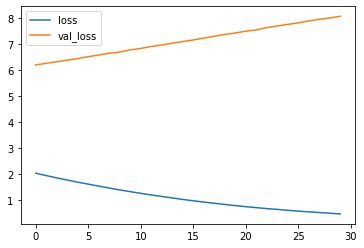

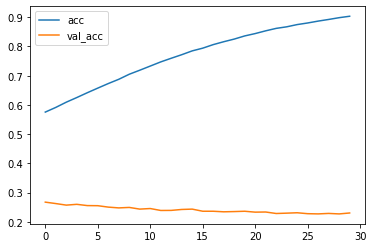

In [43]:
#plotting training results
plt.plot(res.history['loss'], label='loss')
plt.plot(res.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(res.history['acc'], label='acc')
plt.plot(res.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [67]:
#predictions

encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)
encoder_to_attention = Input(shape=(Tx, HIDDEN_DIM_ENCODER*2))
decoder_inputs_single = Input(shape=(1,))
#used for predictions later
embedding_layer_target_single = Embedding(vocab_size_target, EMBEDDING_DIM, weights=[embedding_matrix_target])
decoder_inputs_single_x = embedding_layer_target_single(decoder_inputs_single)

context = one_step_attention(encoder_to_attention, initial_s)
decoder_lstm_input = context_prev_word_concatenator([context, decoder_inputs_single_x])

o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

decoder_model = Model(inputs=[decoder_inputs_single, encoder_to_attention, initial_s, initial_c], outputs=[decoder_outputs, s, c])

idx2word_input = {i:w for w, i in word2idx_inputs.items()}
idx2word_target = {i:w for w, i in word2idx_target.items()}

def predict_seq(input_seq):
    encoder_out = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0,0] = word2idx_target['<sos>']
    
    eos = word2idx_target['<eos>'] #break if eos 
    
    s = np.zeros((1, HIDDEN_DIM_DECODER))
    c = np.zeros((1, HIDDEN_DIM_DECODER))
    
    output_sentence = []
    for _ in range(Ty):
        o, s, c = decoder_model.predict([target_seq, encoder_out, s, c])
        idx = np.argmax(o.flatten())
        if eos == idx:
            break
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
        target_seq[0,0] = idx
        
    return ' '.join(output_sentence)

In [103]:
def predict_sentence(text):
    text_seq = tokenizer_inputs.texts_to_sequences(text)
    text_encoder_input = pad_sequences(text_seq, maxlen=Tx)
    print('predicted sentence: ', predict_seq(text_encoder_input))

In [117]:
test_inputs = []
test_outputs = []
for i in range(2000):
    test_inputs.append(input_texts[i])
    test_outputs.append(predict_seq(encoder_inputs[i:i+1]))
    
df_test = pd.DataFrame({'inputs': test_inputs, 'outputs': test_outputs})
df_test.to_csv('test_results.csv')